In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [2]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
import tensorflow as tf
#tf.enable_eager_execution()
print(tf.__version__)

2.3.0-rc0


In [4]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git 

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-uf7rxidm
  Running command git clone -q https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-uf7rxidm
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=52324 sha256=e3723d99b7bbf499a8508999eed82351323bcc5d998c5d06e938210bac288fff
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8tntz1u/wheels/39/f7/18/5249c8ee2e8306b27455aca27c3b64d272570ddb0323eefc04
Successfully built tfdiffeq
  Attempting uninstall: tfdiffeq
    Found existing installation: tfdiffeq 0.0.1
    Uninstalling tfdiffeq-0.0.1:
      Successfully uninstalled tfdiffeq-0.0.1


In [5]:
!pip install pysindy

In [6]:
!pip install tensorflow_probability

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [9]:
NUM_SAMPLES = 1000
device = 'cpu:0' # These experiments do not require the GPU. Normally, 'gpu:0' if tf.test.is_gpu_available() else 'cpu:0' should be used.

# Force Float 64
tf.keras.backend.set_floatx('float64')

In [10]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [11]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [12]:
%%time

with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Finished integrating ! Result shape :  (1000, 2)
CPU times: user 1.06 s, sys: 57.8 ms, total: 1.12 s
Wall time: 1.05 s


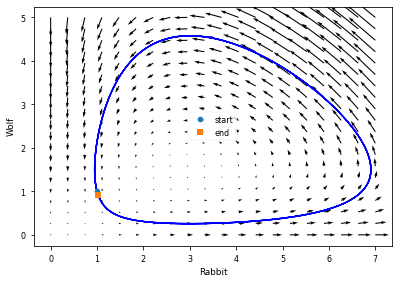

In [13]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Rabbit', ylabel='Wolf', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Rabbit', ylabel='Wolf')

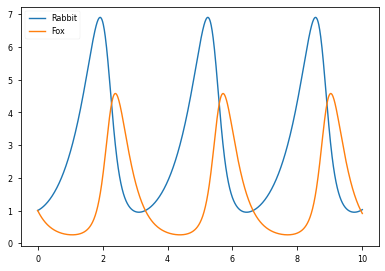

In [14]:
plot_results(t, result, labels=['Rabbit', 'Fox'])

# Universal ODEs

Original Lotke-Volterra system 
>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

For our system, we set $a=1.5$, $b=1$, $c=3.0$, $d=1$

-------

For Universal ODE formulation of the above,

> We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

> We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

Therefore,
>$\frac{\partial R}{\partial T} = aR - U_1(R, F) \\ \frac{\partial F}{\partial T} = -cF + U_2(R, F)$


In [15]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [16]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [17]:
# Lets see the ground truth sample
%%time

with tf.device(device):
  result_train = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
  
print("Finished integrating ! Result shape : ", result_train.shape)

UsageError: Line magic function `%%time` not found.


In [ ]:
plot_results(t_train, result_train, labels=['Rabbit', 'Fox'])

# Train a model

We pretrain the model for a few epochs to reduce the loss quickly, and then retrain the model using BFGS to reduce the loss to a small enough tolerance (say $10^{-6}$).

In [ ]:
%%time

with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

In [ ]:
model.save_weights('model_weights/ckpt', save_format='tf')

In [ ]:
model.load_weights('model_weights/ckpt')

## Finetune the model with BFGS

In [ ]:
#from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [ ]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

### Create a wrapper function for the BFGS optimizer 

BFGS optimizer is somewhat different than SGD or ADAM from Tensorflow. It requires a callable function `loss_func`, which accepts the `model` as input and returns a single float value `loss_value`.

```python
loss_value = loss_func(model)
```

The model is generally a `tf.keras.Model` or its subclasses, and we can use external data as inputs if required to obtain a loss value as shown below.

In [ ]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [ ]:
%%time

model = bfgs_optimizer.minimize(loss_wrapper, model)

# Save your weights and download them !

In [ ]:
model.save_weights('model_weights/ckpt', save_format='tf')

# Load a new model and load these weights (if you didnt train above)

In [ ]:
import os
import requests

def get_checkpoints():
  if not os.path.exists('model_weights'):
      os.makedirs('model_weights')

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/checkpoint')
  with open('./model_weights/checkpoint', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.data-00000-of-00001')
  with open('./model_weights/ckpt.data-00000-of-00001', 'wb') as f:
    f.write(r.content)

  r = requests.get('https://github.com/titu1994/tfdiffeq/releases/download/v0.0.1-pre0/ckpt.index')
  with open('./model_weights/ckpt.index', 'wb') as f:
    f.write(r.content)
  
  print("Pretrained checkpoints retrieved !")

In [ ]:
get_checkpoints()

In [ ]:
model = LotkaVolteraTrainable(a, b, c, d)
model.load_weights('model_weights/ckpt')

# Lets interpolate with our approximate universal ODE !

With a trained Neural ODE that appxoximates the Lotka Voltera system with just 30 samples, lets interpolate within the same timeframe to get a fine solution to the coarse approximate.

In [ ]:
%%time

t_eval = tf.linspace(0., 2, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

# Plot the ODE approximation !

In [ ]:
plot_results(t_eval, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_eval, model_results, labels=['Rabbit_model', 'Fox_model'])

# Lets try and obtain the underlying equations of this system

In [ ]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [ ]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

# Optimize hyper parameters of SRTRidge and the Polynomial Library

In [ ]:
# sindy_optm = SRTRidge(threshold=0.5, alpha=1.0)
sindy_optm = SR3(threshold=0.1, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

# Lets fit the SInDy model !

SInDy is short for "Sparse Identification of Non-linear Dynamical Systems" from the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/content/113/15/3932)

In [ ]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

# Lets compare with the original equations

>$\frac{\partial R}{\partial T} = aR - bRF \\ \frac{\partial F}{\partial T} = -cF + dRF$

Recall, $a=1.5$, $b=1$, $c=3.0$, $d=1$

We substitute $bRF$ with $U_1(R, F)$ in $\frac{\partial R}{\partial T}$.

We substitute $bRF$ with $U_2(R, F)$ in $\frac{\partial F}{\partial T}$.

--------

We compare the above two equations with the one printed below.

We get $a'=1.498$ which is quite close to $a=1.5$, $c'=2.993$, close to the original $c=3.0$.

The equation below approximates $b'=0.997$, close to the $b=1$ we expect. $d'=0.999$ is a closer approximate to our original $d=1$.



In [ ]:
sindy_model.print()

In [ ]:
sindy_model.coefficients()

In [ ]:
sindy_model.equations()

# Compute the $R^2$ score 

In [ ]:
sindy_model.score(model_preds_np, t_eval_np)

# Finding the correct coefficients for the model

We have the ode framework components which correspond to the neural network modules, but we cant be sure that the parameters found are correctly found by SInDy.

We can refit the model (but now replacing correct components and removing the corresponding neural network component), and try to estimate the parameters from the train set.

In [ ]:
device = 'cpu:0' 

In [ ]:
class LotkaVolteraParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    
    # Can also initialize with the values found above for much faster convergence !
    # self.parameters = tf.Variable([1.498, 0.997, 2.993, 0.999], dtype=tf.float64)
    self.parameters = tf.Variable(tf.random.uniform(shape=[4], dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Apply abs, because we want to ensure these parameters are > 0
    params = tf.math.abs(self.parameters)
    a, b, c, d = tf.unstack(params)
    
    dR_dT = a * r - b * r * f
    dF_dT = -c * f + d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [ ]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 25
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5

In [ ]:
%%time

with tf.device(device):
  model = LotkaVolteraParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

In [ ]:
model.save_weights('Weights_LV.ckpt', save_format='tf')

In [ ]:
Weights=model.load_weights('Weights_LV.ckpt')

In [ ]:
type(Weights)

In [ ]:
Weights

In [ ]:
Wei=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'layer1/weights')

In [ ]:
Bia=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, 'layer1/bias')

In [ ]:
def get_weights():
  return [v for v in tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES) 
  if v.name.endswith('weights:0')]

In [ ]:
Weig=get_weights

In [ ]:
sess = tf.compat.v1.Session()
tvars = tf.compat.v1.trainable_variables()
tvars_vals = sess.run(tvars)

for var, val in zip(tvars, tvars_vals):
    print(var.name, val)  # Prints the name of the variable alongside its value.

In [ ]:
print(model.trainable_variables) 

In [ ]:
# Dump weights
for layerNum, layer in enumerate(model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} \
                  -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

In [ ]:
for layerNum, layer in enumerate(model.layers):
    print(layerNum)

In [ ]:
model

In [ ]:
with tf.compat.v1.variable_scope('layer1', reuse=True):
     tf.compat.v1.get_variable('weights')

In [ ]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [ ]:
def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss

In [ ]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

## Lets print the learned parameters of this ODE

In [ ]:
params = tf.math.abs(model.trainable_variables[0])
params.numpy().tolist()

# Finally, lets extrapolate the derived ODE !

In [ ]:
%%time

a_dash = 1.4999991609739252
b_dash = 0.9999962444516388
c_dash = 2.999976055259427
d_dash = 0.9999915353099846

t_extrapolate = tf.linspace(0., 10.0, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

In [ ]:
plot_results(t_extrapolate, real_results, labels=['Rabbit_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Rabbit_model', 'Fox_model'])

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

NUM_SAMPLES=89
a = 0.28
b = 0.2
c = .01

mu = 0.000046948
nu = 0.00001589
# mu = 0.0
# nu = 0.0
N  = 128932753
S0 = (N-4)/N
I0 = 4/N
R0 = 0

t = tf.linspace(0., 89., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)

In [22]:
class SIR(tf.keras.Model):
  
  def __init__(self, a, b, c, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c = a, b, c
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f,g= tf.unstack(y)


    dS_dT = mu - ( self.a*f + nu   )*r   
    dI_dT = ( self.a*f + nu   )*r -(self.b + nu)*f     
    dP_dT = self.c*f
    
    return tf.stack([dS_dT,dI_dT,dP_dT])

In [23]:
%%time

with tf.device(device):
#     result = odeint(SIR(a, b, c), initial_states, t,method='rk4')
#     result = odeint(SIR(a, b, c), initial_states, t,method='adams')
     result = odeint(SIR(a, b, c), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Finished integrating ! Result shape :  (89, 3)
CPU times: user 170 ms, sys: 8.5 ms, total: 178 ms
Wall time: 159 ms


In [24]:
np.shape(result)

TensorShape([89, 3])

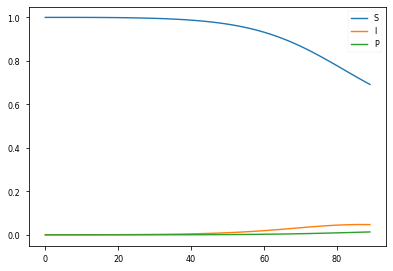

In [25]:
plot_results(t, result, labels=['S', 'I','P'])

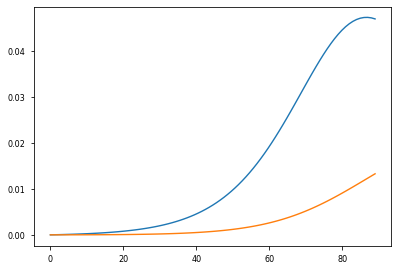

In [26]:
plt.plot(t, result[:,1], t, result[:,2])

In [27]:
class SIRParameters(tf.keras.Model):
  
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

    # Can also initialize with the values found above for much faster convergence !
    self.parameters = tf.Variable([.28, .2, .01], dtype=tf.float64)
#    self.parameters = tf.Variable(tf.random.uniform(shape=[3], minval=0, maxval=1,dtype=tf.float64))
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f,g = tf.unstack(y)

    # Apply abs, because we want to ensure these parameters are > 0
    params = tf.math.abs(self.parameters)
    a, b, c = tf.unstack(params)

    dS_dT = mu - ( a*f + nu   )*r   
    dI_dT = ( a*f + nu   )*r -(b + nu)*f     
    dP_dT = c*f
    
    return tf.stack([dS_dT,dI_dT,dP_dT])    

In [28]:
epochs = 10000
initial_learning_rate = 0.1
decay_steps = 100
decay_rate = 0.5


t_train = tf.linspace(0., 89., num=89)  # Train for the days of the pandemic
initial_states_train = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

In [32]:
data=pd.read_csv("covidMexico.csv")
yobs=data[["New cases (HUC)","Deaths (HUC)"]]
y_obs=yobs.to_numpy()
y_real=tf.convert_to_tensor(y_obs, dtype=tf.float64)

In [ ]:
%%time

with tf.device(device):
  model = SIRParameters()

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adadelta(learning_rate)

  print("Computing ground truth...")
#  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)
#  y_real = tf.convert_to_tensor(yobs, dtype=tf.float64)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      y_hat = tf.transpose(tf.stack([preds[:,1],preds[:,2]]))
      loss = tf.reduce_mean(tf.square(y_real - N*y_hat), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()

Computing ground truth...
Ground truth shape : (89, 2)
Epoch 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Loss : 4378536202077.0156
LR : 0.09930925

Epoch 2
Loss : 4295660883227.2305
LR : 0.09862327

Epoch 3
Loss : 4214062001052.274
LR : 0.09794203

Epoch 4
Loss : 4134247693511.1904
LR : 0.0972655

Epoch 5
Loss : 4056419385301.407
LR : 0.09659363

Epoch 6
Loss : 3980658520856.467
LR : 0.09592641

Epoch 7
Loss : 390698

In [ ]:
tolerance = 1e-1
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [ ]:
def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-3, rtol=1e-3)
  y_hat = tf.transpose(tf.stack([preds[:,1],preds[:,2]]))
  loss = tf.reduce_mean(tf.square(y_real - N*y_hat))
  return loss

In [ ]:
model = bfgs_optimizer.minimize(loss_wrapper, model)

In [ ]:
params = tf.math.abs(model.trainable_variables[0])
params.numpy().tolist()

In [ ]:
a_dash = 0.2944932012466365
b_dash = 0.01259975623864584
c_dash = 0.014807657555633421


t_extrapolate = tf.linspace(0., 120, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = SIR(a_dash, b_dash, c_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
#    real_results = odeint(SIR(a, b, c), initial_states_extrapolate, t_extrapolate)

In [ ]:
#plot_results(t_extrapolate, real_results, labels=['S_real', 'Fox_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['S_model', 'I_model','P_model'])

In [ ]:
a_dash, b_dash,c_dash=  0.2747860575935803, 0.20509276253250144, 0.00614110333871718


t_extrapolate = tf.linspace(0., 120, num=1000)  # Train for just 3 seconds of input
initial_states_extrapolate = tf.convert_to_tensor([S0, I0,R0], dtype=tf.float64)
#initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = SIR(a_dash, b_dash, c_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
#    real_results = odeint(SIR(a, b, c), initial_states_extrapolate, t_extrapolate)

In [ ]:
np.shape(extrapolated_results)

In [ ]:
plt.plot(t_train, y_obs[:,0],'r.', t_train, y_obs[:,1],'b.')
plt.plot(t_extrapolate, N*extrapolated_results[:,1], 
         t_extrapolate, N*extrapolated_results[:,2])